In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**India Pines**

In [3]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input

# --- Chargement des données ---
indian_pines_path = "/content/drive/MyDrive/Hyperspectral_Data/Indian_pines.mat"
indian_pines_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/Indian_pines_gt.mat"
indian_pines_data = sio.loadmat(indian_pines_path)['indian_pines']
gt = sio.loadmat(indian_pines_gt_path)['indian_pines_gt']

# --- Normaliser ---
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

indian_pines_normalized = normalize_data(indian_pines_data)

# --- PCA ---
def dimension_PCA(data, input_dimension):
    height, width, bands = data.shape
    flattened_data = data.reshape(height * width, bands)
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(height, width, input_dimension)
    return whole_pca

indian_pines_pca = dimension_PCA(indian_pines_normalized, 10)
print("Shape after PCA:", indian_pines_pca.shape)

# --- Paramètres ---
patch_size = 5
half_patch = patch_size // 2

# --- Liste des classes ---
indian_pines_classes = [
    'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture',
    'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats',
    'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat',
    'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'
]

# --- Palette de couleurs ---
palette = plt.get_cmap('tab20')
class_colors = {
    0: [0, 0, 0],  # Background (Noir)
    1: [int(c*255) for c in palette(0)[:3]],  # Alfalfa
    2: [int(c*255) for c in palette(1)[:3]],  # Corn-notill
    3: [int(c*255) for c in palette(2)[:3]],  # Corn-mintill
    4: [int(c*255) for c in palette(3)[:3]],  # Corn
    5: [int(c*255) for c in palette(4)[:3]],  # Grass-pasture
    6: [int(c*255) for c in palette(5)[:3]],  # Grass-trees
    7: [int(c*255) for c in palette(6)[:3]],  # Grass-pasture-mowed
    8: [int(c*255) for c in palette(7)[:3]],  # Hay-windrowed
    9: [int(c*255) for c in palette(8)[:3]],  # Oats
   10: [int(c*255) for c in palette(9)[:3]], # Soybean-notill
   11: [int(c*255) for c in palette(10)[:3]], # Soybean-mintill
   12: [int(c*255) for c in palette(11)[:3]], # Soybean-clean
   13: [int(c*255) for c in palette(12)[:3]], # Wheat
   14: [int(c*255) for c in palette(13)[:3]], # Woods
   15: [int(c*255) for c in palette(14)[:3]], # Buildings
   16: [int(c*255) for c in palette(15)[:3]]  # Stone-Steel-Towers
}


# --- Fonction pour extraire les patchs ---
def extract_patches_labels(data, gt, patch_size):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

    patches = []
    labels = []

    for r in range(margin, data.shape[0] + margin):
        for c in range(margin, data.shape[1] + margin):
            label = gt[r - margin, c - margin]
            if label != 0:  # Ignorer le background
                patch = padded_data[r - margin:r + margin + 1, c - margin:c + margin + 1, :]
                patches.append(patch)
                labels.append(label - 1)  # Classes entre 0 et 15

    patches = np.array(patches)
    labels = np.array(labels)
    return patches, labels

# --- Extraire les données ---
patches, labels = extract_patches_labels(indian_pines_pca, gt, patch_size)
patches = np.expand_dims(patches, axis=-1)  # Pour Conv3D : (N, 5, 5, 10, 1)

print(patches.shape)


Shape after PCA: (145, 145, 10)
(10249, 5, 5, 10, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 5, 5, 10, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 2, 2, 10, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 2, 2, 10, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 715,984 (2.73 MB)

 Trainable params: 715,984 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4435 - loss: 1.7877 - val_accuracy: 0.6351 - val_loss: 0.9335
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6245 - loss: 1.0052 - val_accuracy: 0.7034 - val_loss: 0.7747
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6967 - loss: 0.7987 - val_accuracy: 0.8023 - val_loss: 0.5890
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7521 - loss: 0.6497 - val_accuracy: 0.8322 - val_loss: 0.4719
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7941 - loss: 0.5662 - val_accuracy: 0.8576 - val_loss: 0.4130
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8114 - loss: 0.5124 - val_accuracy: 0.8787 - val_loss: 0.3535
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8392 - loss: 0.4440 - val_accuracy: 0.9021 - val_loss: 0.2986
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8577 - loss: 0.3961 - val_accuracy: 0

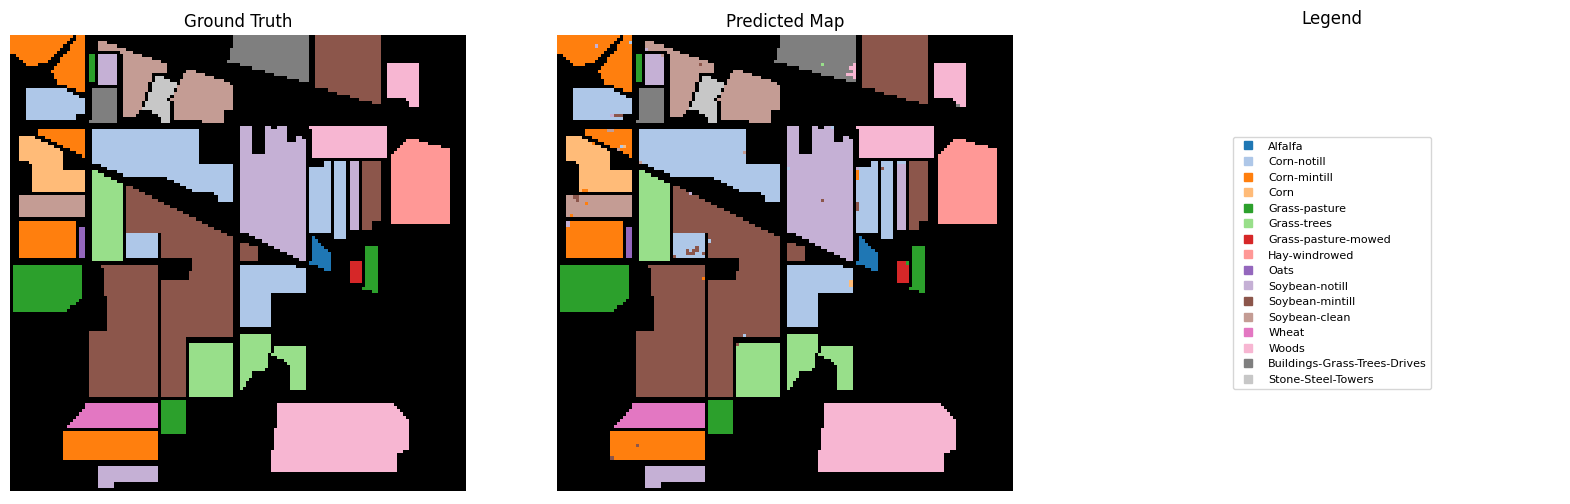

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# --- Split en train/test ---
X_train, X_test, y_train, y_test = train_test_split(patches, labels, test_size=0.3, random_state=42, stratify=labels)

# --- Modèle 3D CNN ---
input_shape = (patch_size, patch_size, 10, 1)

model = Sequential([
    Input(shape=input_shape),
    Conv3D(32, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,1)),
    Conv3D(64, (3,3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(indian_pines_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Entraînement ---
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# --- Prédiction sur toute l'image ---
def fast_predict_whole_image_3d(data, model, patch_size, batch_size=2048, ground_truth=None):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

    patches = []
    positions = []

    for r in range(margin, data.shape[0] + margin):
        for c in range(margin, data.shape[1] + margin):
            if ground_truth is not None and ground_truth[r - margin, c - margin] == 0:
                continue  # Ignore le background
            patch = padded_data[r - margin:r + margin + 1, c - margin:c + margin + 1, :]
            patch = np.expand_dims(patch, axis=-1)
            patches.append(patch)
            positions.append((r - margin, c - margin))

    patches = np.array(patches)
    print(f"Total patches to predict (without background): {patches.shape[0]}")

    predictions = []
    for i in range(0, len(patches), batch_size):
        batch = patches[i:i+batch_size]
        preds = model.predict(batch, verbose=0)
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)

    predicted_labels = np.zeros((data.shape[0], data.shape[1]))  # Tout à 0 = background
    for idx, (r, c) in enumerate(positions):
       predicted_labels[r, c] = predictions[idx] + 1

    return predicted_labels

predicted_map = fast_predict_whole_image_3d(indian_pines_pca, model, patch_size, ground_truth=gt)
def plot_prediction_and_ground_truth(gt_labels, predicted_labels, class_colors, class_names):
    h, w = gt_labels.shape

    gt_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    pred_rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Ground truth
    for label in range(len(class_names)+1):
        color = class_colors.get(label, [0,0,0])
        gt_rgb[gt_labels == label] = color

    # Prediction
    for r in range(h):
        for c in range(w):
            pred_label = predicted_labels[r, c]
            pred_rgb[r, c] = class_colors.get(pred_label, [0,0,0])


    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].imshow(gt_rgb)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')

    axs[1].imshow(pred_rgb)
    axs[1].set_title('Predicted Map')
    axs[1].axis('off')

    patches = [plt.plot([],[], marker="s", ls="", color=np.array(class_colors[i+1])/255, label=class_names[i])[0] for i in range(len(class_names))]
    axs[2].legend(handles=patches, loc='center', fontsize=8)
    axs[2].axis('off')
    axs[2].set_title('Legend')

    plt.show()


# --- Affichage final ---
plot_prediction_and_ground_truth(gt, predicted_map, class_colors, indian_pines_classes)

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the arrays (on les transforme en 1D pour comparer pixel par pixel)
gt_flat = gt.flatten()
pred_flat = predicted_map.flatten()

# Calcul de la confusion matrix
cm = confusion_matrix(gt_flat, pred_flat)

cm


array([[10776,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    0,    45,     0,     0,     0,     0,     0,     0,     1,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,  1405,     1,     3,     0,     0,     0,     0,
            0,     5,    12,     2,     0,     0,     0,     0],
       [    0,     0,     1,   822,     0,     0,     0,     0,     0,
            0,     1,     5,     0,     1,     0,     0,     0],
       [    0,     0,     0,     1,   236,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,   482,     0,     0,     0,
            0,     0,     0,     0,     0,     1,     0,     0],
       [    0,     0,     0,     0,     0,     0,   729,     0,     0,
            0,     0,     1,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(gt_flat, pred_flat))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10776
           1       1.00      0.98      0.99        46
           2       0.99      0.98      0.99      1428
           3       0.99      0.99      0.99       830
           4       0.98      1.00      0.99       237
           5       1.00      1.00      1.00       483
           6       1.00      1.00      1.00       730
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00       478
           9       1.00      1.00      1.00        20
          10       0.99      0.99      0.99       972
          11       0.99      1.00      0.99      2455
          12       0.99      0.99      0.99       593
          13       1.00      1.00      1.00       205
          14       0.99      1.00      1.00      1265
          15       1.00      0.98      0.99       386
          16       1.00      0.97      0.98        93

  

### Predicting Class 0

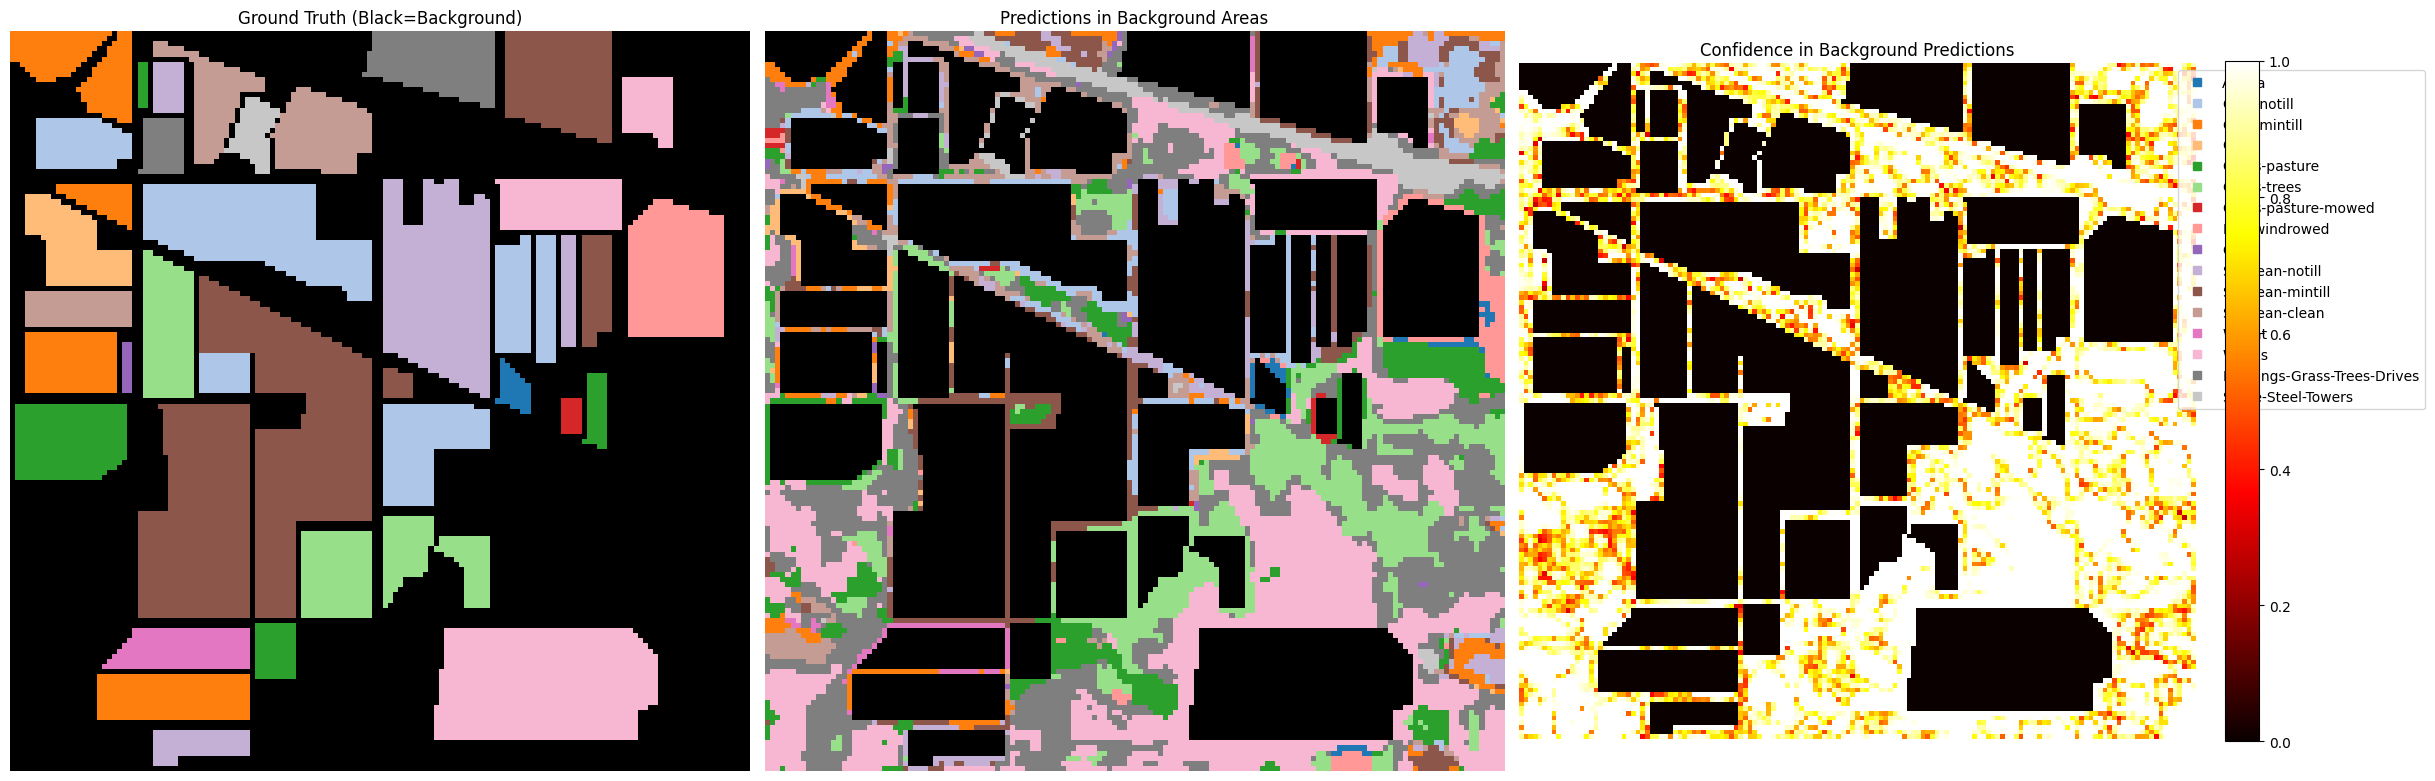


Background Prediction Analysis:
Total background pixels: 10776
Class 1 (Alfalfa): 63 pixels (avg confidence: 0.86)
Class 2 (Corn-notill): 467 pixels (avg confidence: 0.83)
Class 3 (Corn-mintill): 386 pixels (avg confidence: 0.84)
Class 4 (Corn): 118 pixels (avg confidence: 0.82)
Class 5 (Grass-pasture): 858 pixels (avg confidence: 0.89)
Class 6 (Grass-trees): 1330 pixels (avg confidence: 0.92)
Class 7 (Grass-pasture-mowed): 33 pixels (avg confidence: 0.79)
Class 8 (Hay-windrowed): 234 pixels (avg confidence: 0.90)
Class 9 (Oats): 32 pixels (avg confidence: 0.71)
Class 10 (Soybean-notill): 329 pixels (avg confidence: 0.83)
Class 11 (Soybean-mintill): 669 pixels (avg confidence: 0.86)
Class 12 (Soybean-clean): 583 pixels (avg confidence: 0.81)
Class 13 (Wheat): 93 pixels (avg confidence: 0.84)
Class 14 (Woods): 2557 pixels (avg confidence: 0.93)
Class 15 (Buildings-Grass-Trees-Drives): 2620 pixels (avg confidence: 0.88)
Class 16 (Stone-Steel-Towers): 404 pixels (avg confidence: 0.92)


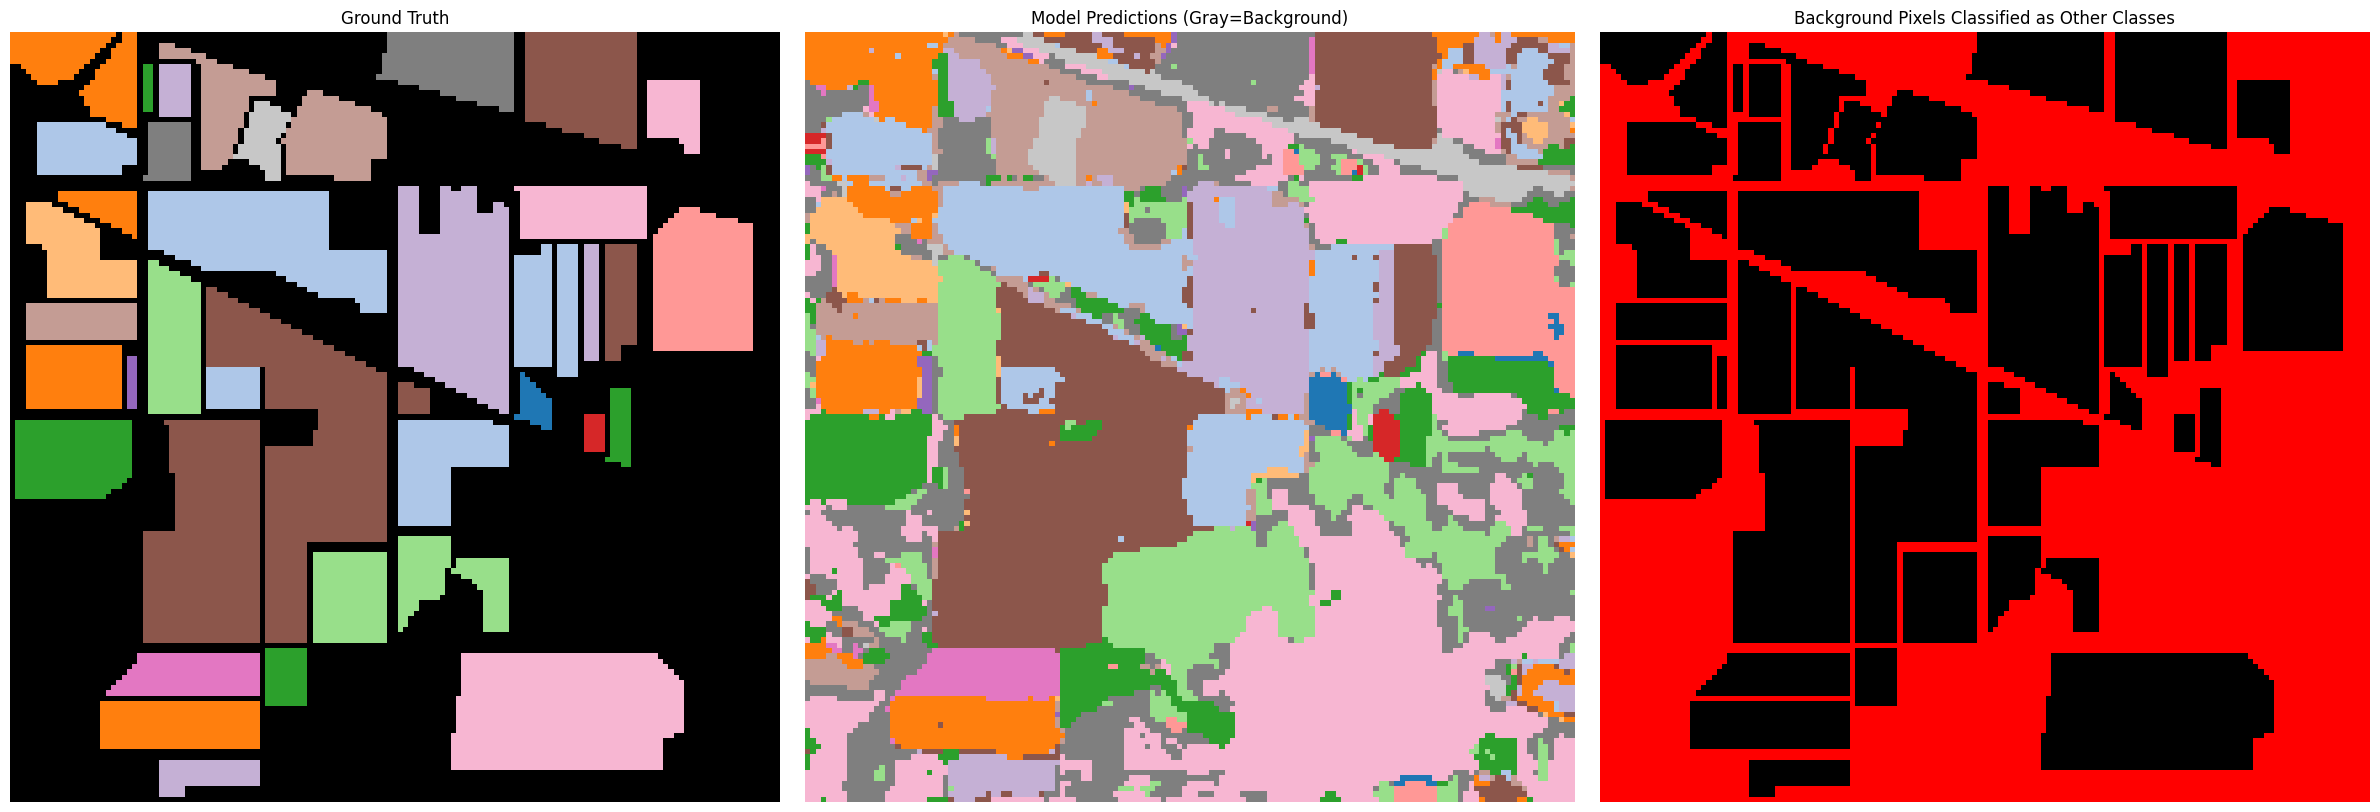

In [5]:
# --- New Prediction Function to Include Background ---
def predict_with_background(data, model, patch_size, batch_size=2048):
    """
    Predicts on all pixels including background (class 0)
    Returns:
    - predicted_map: predictions (0-16, where 0 is background)
    - confidence_map: confidence scores
    """
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

    height, width = data.shape[:2]
    predicted_map = np.zeros((height, width))
    confidence_map = np.zeros((height, width))

    # Prepare all positions
    positions = [(r, c) for r in range(height) for c in range(width)]

    # Process in batches
    for i in range(0, len(positions), batch_size):
        batch_pos = positions[i:i+batch_size]
        batch_patches = []

        for r, c in batch_pos:
            patch = padded_data[r:r+patch_size, c:c+patch_size, :]
            patch = np.expand_dims(patch, axis=-1)
            batch_patches.append(patch)

        batch_patches = np.array(batch_patches)
        preds = model.predict(batch_patches, verbose=0)

        # Store predictions (adding 1 to convert 0-15 to 1-16)
        for j, (r, c) in enumerate(batch_pos):
            predicted_map[r, c] = np.argmax(preds[j]) + 1
            confidence_map[r, c] = np.max(preds[j])

    return predicted_map, confidence_map

# --- Visualization Function for Background Analysis ---
def visualize_background_predictions(gt, predictions, confidence, class_colors, class_names):
    """
    Visualizes where the model predicts classes in background areas
    """
    # Create RGB images
    gt_rgb = np.zeros((*gt.shape, 3), dtype=np.uint8)
    pred_rgb = np.zeros((*predictions.shape, 3), dtype=np.uint8)

    # Ground truth (background in black)
    for label in range(17):
        color = class_colors.get(label, [0,0,0])
        gt_rgb[gt == label] = color

    # Predictions (background areas where model predicted classes)
    background_mask = (gt == 0)
    pred_in_bg = predictions.copy()
    pred_in_bg[~background_mask] = 0  # Only keep predictions in background

    for label in range(1, 17):
        color = class_colors.get(label, [0,0,0])
        pred_rgb[pred_in_bg == label] = color

    # Confidence in background areas
    bg_confidence = confidence.copy()
    bg_confidence[~background_mask] = 0

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    ax1.imshow(gt_rgb)
    ax1.set_title('Ground Truth (Black=Background)')
    ax1.axis('off')

    ax2.imshow(pred_rgb)
    ax2.set_title('Predictions in Background Areas')
    ax2.axis('off')

    conf_plot = ax3.imshow(bg_confidence, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(conf_plot, ax=ax3, fraction=0.046, pad=0.04)
    ax3.set_title('Confidence in Background Predictions')
    ax3.axis('off')

    # Create legend
    patches = [plt.plot([],[], marker="s", ls="", color=np.array(class_colors[i+1])/255,
               label=class_names[i])[0] for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.35, 1), loc='upper right')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nBackground Prediction Analysis:")
    print(f"Total background pixels: {np.sum(background_mask)}")
    for class_id in range(1, 17):
        class_pixels = np.sum((predictions == class_id) & background_mask)
        if class_pixels > 0:
            avg_conf = np.mean(confidence[(predictions == class_id) & background_mask])
            print(f"Class {class_id} ({class_names[class_id-1]}): {class_pixels} pixels (avg confidence: {avg_conf:.2f})")

# --- Run the Prediction ---
# Make predictions on entire image (including background areas)
predicted_map, confidence_map = predict_with_background(indian_pines_pca, model, patch_size)

# Visualize results
visualize_background_predictions(gt, predicted_map, confidence_map, class_colors, indian_pines_classes)

# Optional: Create a combined visualization showing:
# 1. Ground truth with background
# 2. Model predictions (with background as gray)
# 3. Areas where background was misclassified

def plot_combined_results(gt, predictions, class_colors, class_names):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Ground truth
    gt_rgb = np.zeros((*gt.shape, 3), dtype=np.uint8)
    for label in range(17):
        gt_rgb[gt == label] = class_colors.get(label, [0,0,0])
    ax1.imshow(gt_rgb)
    ax1.set_title('Ground Truth')
    ax1.axis('off')

    # Predictions (with background as gray)
    pred_rgb = np.zeros((*predictions.shape, 3), dtype=np.uint8)
    for label in range(1, 17):
        pred_rgb[predictions == label] = class_colors.get(label, [0,0,0])
    pred_rgb[predictions == 0] = [128, 128, 128]  # Gray for background
    ax2.imshow(pred_rgb)
    ax2.set_title('Model Predictions (Gray=Background)')
    ax2.axis('off')

    # Misclassified background
    misclassified = (gt == 0) & (predictions > 0)
    misclass_rgb = np.zeros((*gt.shape, 3), dtype=np.uint8)
    misclass_rgb[misclassified] = [255, 0, 0]  # Red for misclassified background
    ax3.imshow(misclass_rgb)
    ax3.set_title('Background Pixels Classified as Other Classes')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

plot_combined_results(gt, predicted_map, class_colors, indian_pines_classes)

#**Pavia University**

In [6]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input
pavia_university_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU.mat"
pavia_university_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU_gt.mat"

# Charger Pavia University
PaviaU_data = sio.loadmat(pavia_university_path)['paviaU']
PaviaU_gt = sio.loadmat(pavia_university_gt_path)['paviaU_gt']


# --- Normaliser ---
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

pavia_normalized = normalize_data(PaviaU_data)

# --- PCA ---
def dimension_PCA(data, input_dimension):
    height, width, bands = data.shape
    flattened_data = data.reshape(height * width, bands)
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(height, width, input_dimension)
    return whole_pca

pavia_pca = dimension_PCA(pavia_normalized, 3)
print("Shape after PCA:", pavia_pca.shape)


Shape after PCA: (610, 340, 3)


Shape after PCA: (610, 340, 10)
(42776, 5, 5, 10, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 5, 5, 10, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 2, 10, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 2, 10, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,185 (2.72 MB)

 Trainable params: 714,185 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8113 - loss: 0.5749 - val_accuracy: 0.9700 - val_loss: 0.0841
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9641 - loss: 0.1008 - val_accuracy: 0.9811 - val_loss: 0.0518
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9778 - loss: 0.0641 - val_accuracy: 0.9854 - val_loss: 0.0376
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9829 - loss: 0.0455 - val_accuracy: 0.9905 - val_loss: 0.0298
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9870 - loss: 0.0381 - val_accuracy: 0.9870 - val_loss: 0.0392
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9892 - loss: 0.0318 - val_accuracy: 0.9945 - val_loss: 0.0200
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9901 - loss: 0.0277 - val_accuracy: 0.9948 - val_loss: 0.0153
Epoch 8/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9916 - loss: 0.0233 - val_acc

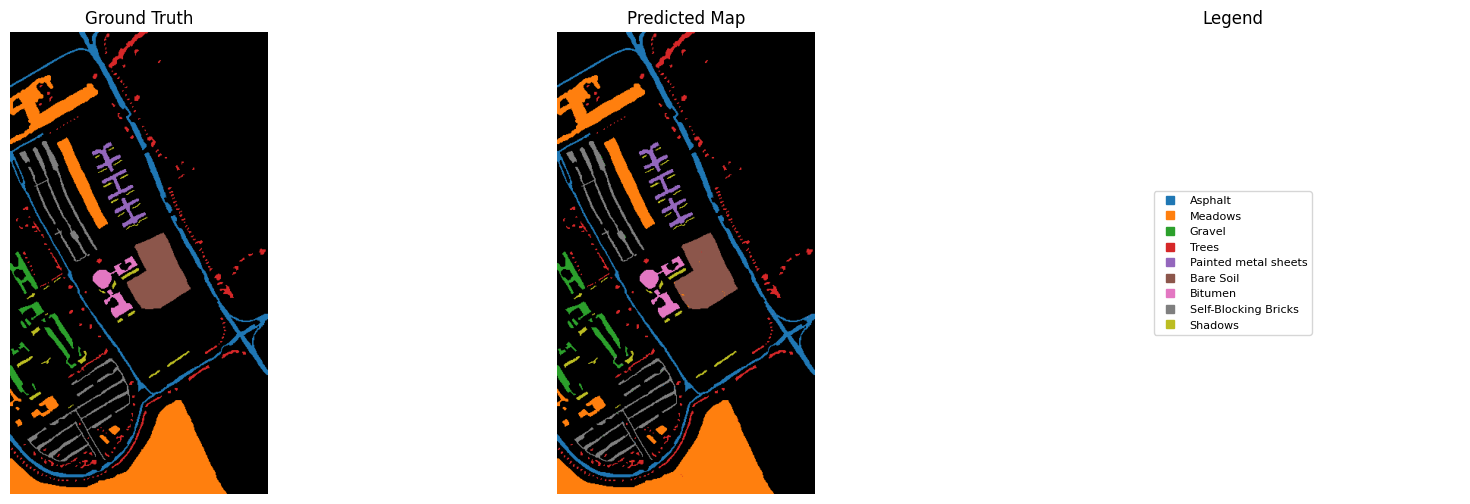

In [7]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- Chargement des données ---
pavia_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU.mat"
pavia_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU_gt.mat"
pavia_data = sio.loadmat(pavia_path)['paviaU']
gt = sio.loadmat(pavia_gt_path)['paviaU_gt']

# --- Normaliser ---
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

pavia_normalized = normalize_data(pavia_data)

# --- PCA ---
def dimension_PCA(data, input_dimension):
    height, width, bands = data.shape
    flattened_data = data.reshape(height * width, bands)
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(height, width, input_dimension)
    return whole_pca

pavia_pca = dimension_PCA(pavia_normalized, 10)  # ou 15 si tu veux tester

print("Shape after PCA:", pavia_pca.shape)

# --- Paramètres ---
patch_size = 5
half_patch = patch_size // 2

# --- Liste des classes ---
pavia_classes = [
    'Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
    'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows'
]

# --- Palette de couleurs ---
palette = plt.get_cmap('tab10')
class_colors = {
    0: [0, 0, 0],  # Background (noir)
    1: [int(c*255) for c in palette(0)[:3]],
    2: [int(c*255) for c in palette(1)[:3]],
    3: [int(c*255) for c in palette(2)[:3]],
    4: [int(c*255) for c in palette(3)[:3]],
    5: [int(c*255) for c in palette(4)[:3]],
    6: [int(c*255) for c in palette(5)[:3]],
    7: [int(c*255) for c in palette(6)[:3]],
    8: [int(c*255) for c in palette(7)[:3]],
    9: [int(c*255) for c in palette(8)[:3]]
}

# --- Fonction pour extraire les patchs ---
def extract_patches_labels(data, gt, patch_size):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

    patches = []
    labels = []

    for r in range(margin, data.shape[0] + margin):
        for c in range(margin, data.shape[1] + margin):
            label = gt[r - margin, c - margin]
            if label != 0:  # Ignorer le background
                patch = padded_data[r - margin:r + margin + 1, c - margin:c + margin + 1, :]
                patches.append(patch)
                labels.append(label - 1)  # Classes entre 0 et 8

    patches = np.array(patches)
    labels = np.array(labels)
    return patches, labels

# --- Extraire les données ---
patches, labels = extract_patches_labels(pavia_pca, gt, patch_size)
patches = np.expand_dims(patches, axis=-1)

print(patches.shape)

# --- Split en train/test ---
X_train, X_test, y_train, y_test = train_test_split(patches, labels, test_size=0.3, random_state=42, stratify=labels)

# --- Modèle 3D CNN ---
input_shape = (patch_size, patch_size, 10, 1)

model = Sequential([
    Input(shape=input_shape),
    Conv3D(32, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,1)),
    Conv3D(64, (3,3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(pavia_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Entraînement ---
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# --- Prédiction sur toute l'image ---
def fast_predict_whole_image_3d(data, model, patch_size, batch_size=2048, ground_truth=None):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

    patches = []
    positions = []

    for r in range(margin, data.shape[0] + margin):
        for c in range(margin, data.shape[1] + margin):
            if ground_truth is not None and ground_truth[r - margin, c - margin] == 0:
                continue
            patch = padded_data[r - margin:r + margin + 1, c - margin:c + margin + 1, :]
            patch = np.expand_dims(patch, axis=-1)
            patches.append(patch)
            positions.append((r - margin, c - margin))

    patches = np.array(patches)
    print(f"Total patches to predict (without background): {patches.shape[0]}")

    predictions = []
    for i in range(0, len(patches), batch_size):
        batch = patches[i:i+batch_size]
        preds = model.predict(batch, verbose=0)
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)

    predicted_labels = np.zeros((data.shape[0], data.shape[1]))

    for idx, (r, c) in enumerate(positions):
        predicted_labels[r, c] = predictions[idx] + 1

    return predicted_labels

predicted_map = fast_predict_whole_image_3d(pavia_pca, model, patch_size, ground_truth=gt)

# --- Affichage final ---
def plot_prediction_and_ground_truth(gt_labels, predicted_labels, class_colors, class_names):
    h, w = gt_labels.shape

    gt_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    pred_rgb = np.zeros((h, w, 3), dtype=np.uint8)

    for label in range(len(class_names)+1):
        color = class_colors.get(label, [0,0,0])
        gt_rgb[gt_labels == label] = color

    for r in range(h):
        for c in range(w):
            pred_label = predicted_labels[r, c]
            pred_rgb[r, c] = class_colors.get(pred_label, [0,0,0])

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].imshow(gt_rgb)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')

    axs[1].imshow(pred_rgb)
    axs[1].set_title('Predicted Map')
    axs[1].axis('off')

    patches = [plt.plot([],[], marker="s", ls="", color=np.array(class_colors[i+1])/255, label=class_names[i])[0] for i in range(len(class_names))]
    axs[2].legend(handles=patches, loc='center', fontsize=8)
    axs[2].axis('off')
    axs[2].set_title('Legend')

    plt.show()

plot_prediction_and_ground_truth(gt, predicted_map, class_colors, pavia_classes)


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the arrays (on les transforme en 1D pour comparer pixel par pixel)
gt_flat = gt.flatten()
pred_flat = predicted_map.flatten()

# Calcul de la confusion matrix
cm = confusion_matrix(gt_flat, pred_flat)

cm


array([[164624,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0,   6631,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0,      0,  18648,      0,      0,      0,      1,      0,
             0,      0],
       [     0,      1,      0,   2092,      0,      0,      0,      0,
             6,      0],
       [     0,      0,      4,      0,   3060,      0,      0,      0,
             0,      0],
       [     0,      0,      0,      0,      0,   1345,      0,      0,
             0,      0],
       [     0,      0,      0,      0,      0,      0,   5029,      0,
             0,      0],
       [     0,      0,      0,      0,      0,      0,      0,   1330,
             0,      0],
       [     0,      2,      0,     15,      0,      0,      0,      0,
          3665,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,    947]])

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(gt_flat, pred_flat))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       1.00      1.00      1.00      6631
           2       1.00      1.00      1.00     18649
           3       0.99      1.00      0.99      2099
           4       1.00      1.00      1.00      3064
           5       1.00      1.00      1.00      1345
           6       1.00      1.00      1.00      5029
           7       1.00      1.00      1.00      1330
           8       1.00      1.00      1.00      3682
           9       1.00      1.00      1.00       947

    accuracy                           1.00    207400
   macro avg       1.00      1.00      1.00    207400
weighted avg       1.00      1.00      1.00    207400



Predicting Backgroud (class 0)

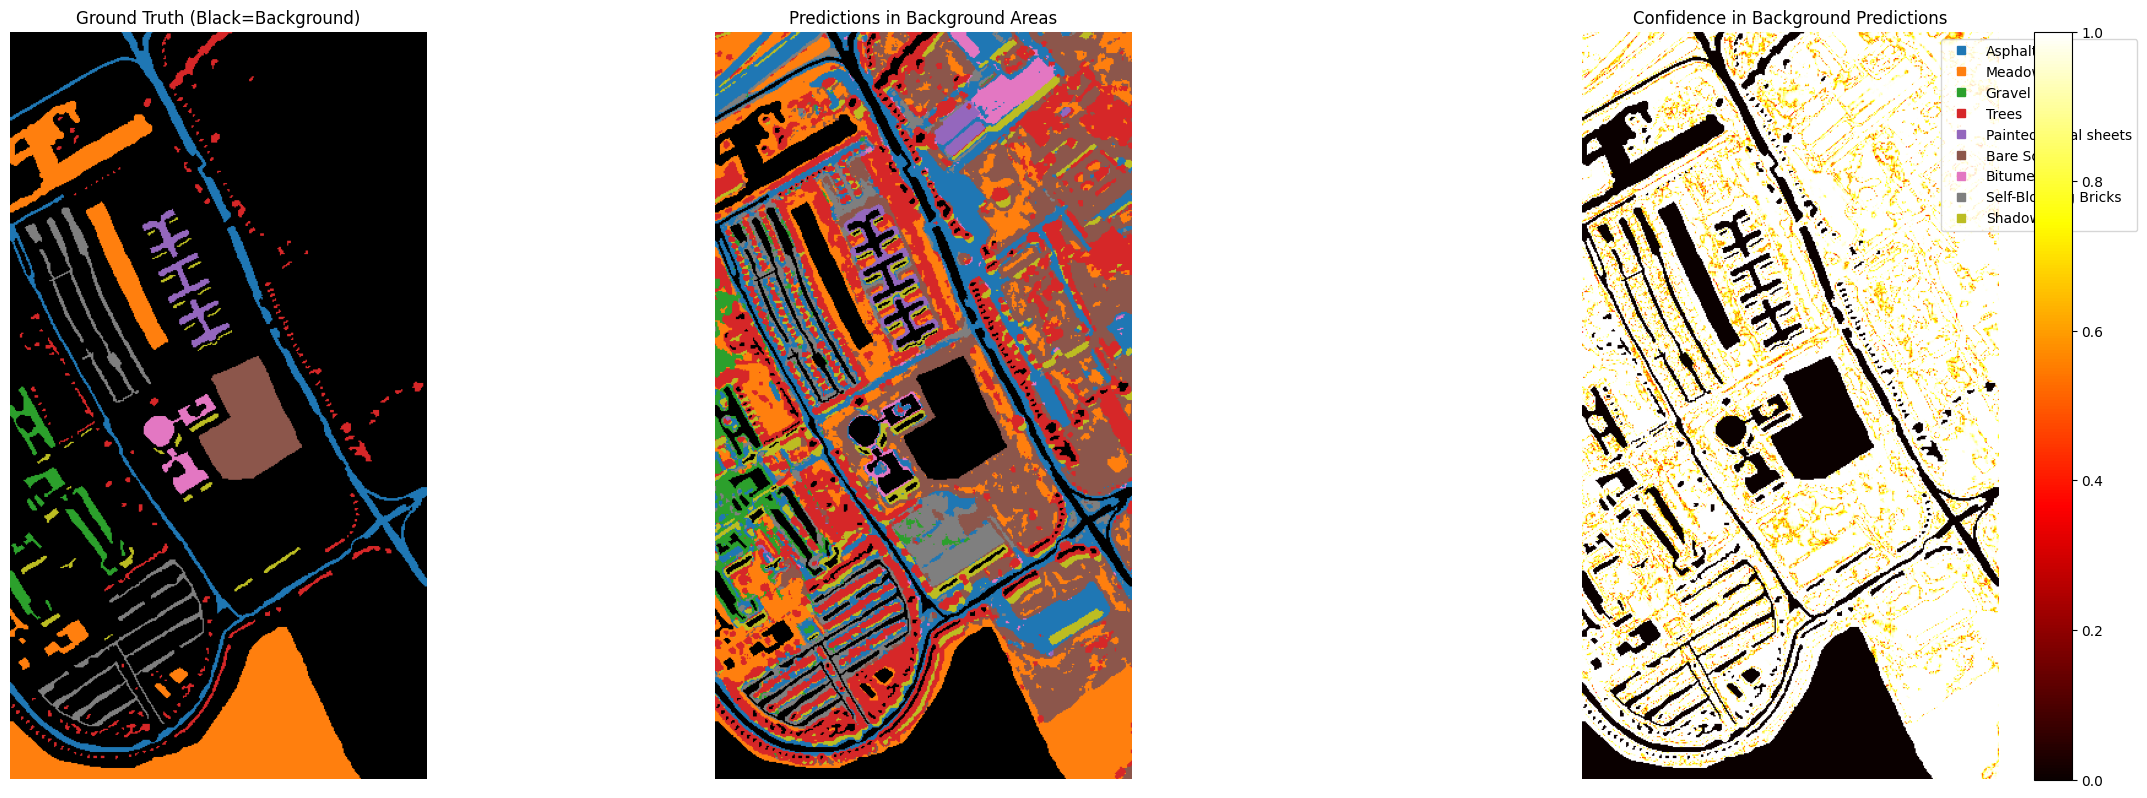


Background Prediction Analysis:
Total background pixels: 164624
Class 1 (Asphalt): 27969 pixels (avg confidence: 0.95)
Class 2 (Meadows): 28274 pixels (avg confidence: 0.95)
Class 3 (Gravel): 4501 pixels (avg confidence: 0.91)
Class 4 (Trees): 40817 pixels (avg confidence: 0.97)
Class 5 (Painted metal sheets): 2378 pixels (avg confidence: 0.98)
Class 6 (Bare Soil): 36415 pixels (avg confidence: 0.96)
Class 7 (Bitumen): 2748 pixels (avg confidence: 0.93)
Class 8 (Self-Blocking Bricks): 12058 pixels (avg confidence: 0.92)
Class 9 (Shadows): 9464 pixels (avg confidence: 0.95)


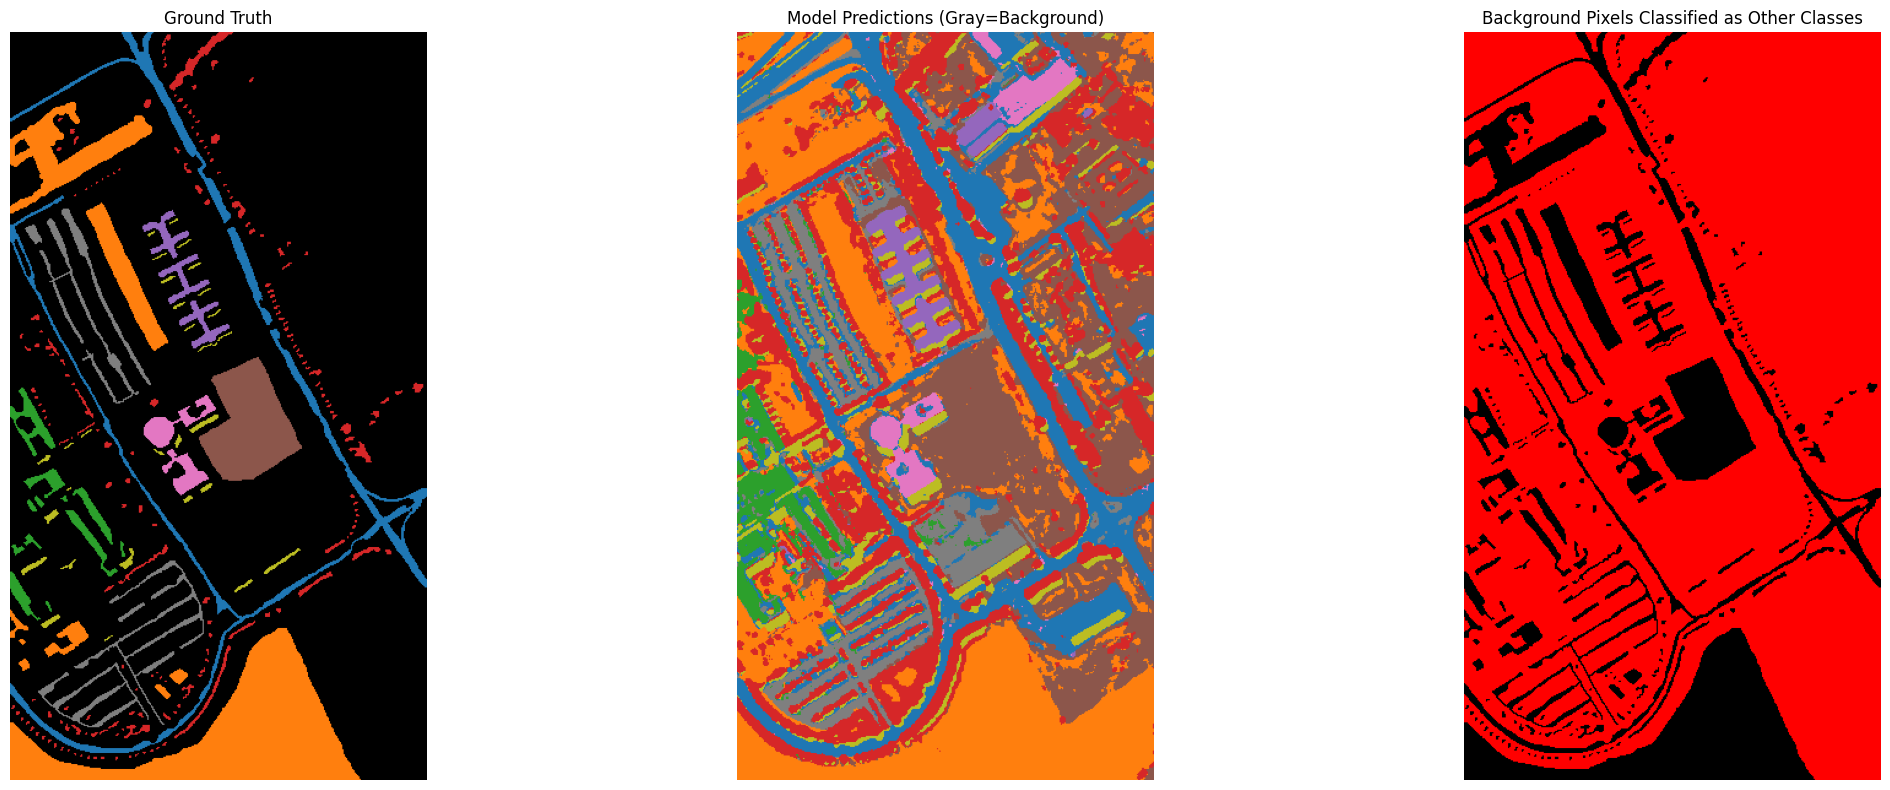

In [8]:
# --- Run the Prediction ---
# Make predictions on entire image (including background areas)
predicted_map, confidence_map = predict_with_background(pavia_pca, model, patch_size)

# Visualize results
visualize_background_predictions(gt, predicted_map, confidence_map, class_colors, pavia_classes)

# Optional: Create a combined visualization showing:
# 1. Ground truth with background
# 2. Model predictions (with background as gray)
# 3. Areas where background was misclassified

plot_combined_results(gt, predicted_map, class_colors, pavia_classes)